In [1]:
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
import matplotlib

In [3]:
mypath = '/raid/yifan/RBM/Measured_stratified_temp_from_TVA/measured_data'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
raw = pd.read_fwf('/raid3/rniemeyr/RBM/two_layer_model/RBM_Yixin/RIPS/model_run/source/VIC_RBM/src/fort.32', header = None)

In [8]:
raw.index = pd.date_range('1949-01-01','2010-12-31')
raw.columns = ['time', 'T_epil_res1', 'T_epil_res2', 'T_epil_res3', 'T_epil_res4', 'T_hypo_res1', 'T_hypo_res2', 'T_hypo_res3' , 'T_hypo_res4' ]
#raw.columns = ['time', 'T_epil_res4', 'T_hypo_res4' ]
raw = raw.drop('time',1)

In [9]:
temp_measure = pd.DataFrame()
temp_model = pd.DataFrame()
depth_divide = []
depth_temp = []

for j in range(len(onlyfiles)):
#for j in [0]:
    print(j)
    filename = mypath + '/' + onlyfiles[j]
    x = pd.ExcelFile(filename)
    sheet_name = x.sheet_names
    
#    plt.figure(figsize=[10,6])
#    plt.xlabel('Temperature(' + r"$^o$" + 'C)', fontsize = 10)
#    plt.ylabel('Depth (m)')
#    plt.gca().invert_yaxis()
    
    for i in range(len(sheet_name)):
    #for i in range(4):
#    for i in [0]:
        data = x.parse(sheet_name[i], skiprows = [0,2], header = [0])
        if any(np.isnan(data['Temp'])):
            data = data.dropna()
#        f, = plt.plot(data['Temp'],data['Depth'],label = i,linewidth = 2)
#        f.set_label(i)
#        plt.legend()
        str1 = sheet_name[i]
        a = re.findall('\d+', str1 )
        T_top    = data['Temp'].iloc[-1]
        T_bottom = data['Temp'].iloc[0]
        
        top_6 = data.loc[data['Depth'] <= 6.4]
        bottom_9 = data.loc[(data['Depth']>6.4) & (data['Depth'] <= 16.)]
        bottom_25 = data.loc[(data['Depth']>6.4) & (data['Depth'] <= 31.4)]
        bottom_all = data.loc[data['Depth']>6.4]
        
        depth_top = np.array(top_6['Depth'])
        depth_bottom_9 = np.array(bottom_9['Depth'])
        depth_bottom_25 = np.array(bottom_25['Depth'])
        depth_bottom_all = np.array(bottom_all['Depth'])
        
        T_epil_measure_top6 = ((depth_top - np.concatenate([depth_top[1:],[0]]))*(np.array(top_6['Temp']))).sum()/depth_top[0]
        T_hypo_measure_bottom_9 = (((depth_bottom_9 - np.concatenate([depth_bottom_9[1:],[depth_top[0]]])))*(np.array(bottom_9['Temp']))).sum()/(depth_bottom_9[0] - depth_top[0])
        T_hypo_measure_bottom_25 = (((depth_bottom_25 - np.concatenate([depth_bottom_25[1:],[depth_top[0]]])))*(np.array(bottom_25['Temp']))).sum()/(depth_bottom_25[0] - depth_top[0])
        T_hypo_measure_bottom_all = (((depth_bottom_all - np.concatenate([depth_bottom_all[1:],[depth_top[0]]])))*(np.array(bottom_all['Temp']))).sum()/(depth_bottom_all[0] - depth_top[0])
        
        if (T_top - T_bottom < 2):
            T_epil_measure = data['Temp'].iloc[-1]
            T_hypo_measure = data['Temp'].iloc[0]
            depth_thermal = data['Depth'][0]
            temp_divide = data['Temp'][0]
            depth_divide.append(depth_thermal)
            depth_temp.append(temp_divide)
        
        else: 
            A = np.array(data['Depth'].loc[data['Temp'] >=T_top -2])
            B = np.array(data['Depth'].loc[data['Temp'] < T_top -2])
            T_epil_measure = ((A - np.concatenate([A[1:],[0]]))*np.array(data['Temp'].loc[data['Temp'] >=T_top -2])).sum()/A[0]
            T_hypo_measure = ((B - np.concatenate([B[1:],[A[0]]]))*np.array(data['Temp'].loc[data['Temp'] < T_top -2])).sum()/(B[0] - A[0])
            depth_thermal = A[0]
            temp_divide = np.array(data['Temp'].loc[data['Temp'] >=T_top -2])[0]
            depth_divide.append(depth_thermal)
            depth_temp.append(temp_divide)
        
        index = pd.datetime(int(a[0]),int(a[1]),int(a[2]))
        New_measure = pd.DataFrame([[T_epil_measure,T_hypo_measure, T_epil_measure_top6, T_hypo_measure_bottom_9, T_hypo_measure_bottom_25,\
                                     T_hypo_measure_bottom_all,depth_thermal,temp_divide]]
                                   ,index = [index],columns=['T_epil','T_hypo','T_epil_top_6','T_hypo_bottom_9','T_hypo_bottom_25',\
                                                             'T_hypo_bottom_all','depth_thermalcline','temp_depth'])
        temp_measure = pd.concat([temp_measure,New_measure])

        New_model = raw[raw.index == pd.datetime(int(a[0]),int(a[1]),int(a[2]))]
        temp_model = pd.concat([temp_model,New_model])

0
1
2
3
4
5
6
7
8
9
10
11


In [10]:
combine_temp = pd.concat([temp_model,temp_measure],  axis = 1).dropna(axis = 0)

In [11]:
T_epil_model = combine_temp['T_epil_res4'].values
T_hypo_model = combine_temp['T_hypo_res4'].values
T_epil_measure = combine_temp['T_epil'].values
T_hypo_measure = combine_temp['T_hypo'].values
T_epil_measure_6 = combine_temp['T_epil_top_6'].values
T_hypo_measure_9 = combine_temp['T_hypo_bottom_9'].values
T_hypo_measure_25 = combine_temp['T_hypo_bottom_25'].values
T_hypo_measure_all = combine_temp['T_hypo_bottom_all'].values

In [12]:
day_of_year = []
for i in range(len(combine_temp.index)):
    day_of_year.append(combine_temp.index[i].timetuple().tm_yday)

combine_temp['day_of_year'] = day_of_year

In [13]:
combine_temp

,T_epil_res1,T_epil_res2,T_epil_res3,T_epil_res4,T_hypo_res1,T_hypo_res2,T_hypo_res3,T_hypo_res4,T_epil,T_hypo,T_epil_top_6,T_hypo_bottom_9,T_hypo_bottom_25,T_hypo_bottom_all,depth_thermalcline,temp_depth,day_of_year
2003-05-23,19.325808,20.081444,21.709209,22.557192,9.823008,9.819731,16.638685,16.995810,21.200696,12.750097,21.376000,19.172000,15.793333,14.094405,11.50,20.16,143
2003-06-20,22.563169,23.525576,24.419342,25.487301,12.191803,12.283137,18.620197,20.586281,25.863000,16.399750,24.543167,20.010000,17.585833,15.846486,3.00,25.72,171
2003-07-16,25.068304,26.090889,27.172338,27.916719,14.363598,14.961928,21.533442,24.056396,25.337917,18.445263,25.069310,21.157778,19.636000,18.301081,4.80,24.58,197
2003-07-24,25.660831,26.735388,27.788206,28.365152,14.637938,15.153625,22.489449,24.351631,25.067377,19.196061,25.067377,21.773750,19.993600,19.196061,6.10,24.70,205
2003-08-22,26.745728,28.087738,27.970781,29.388683,16.577906,16.501047,23.603199,26.117826,28.074615,20.430866,27.074833,22.386667,21.081880,20.151611,3.90,27.89,234
2003-09-11,24.372459,25.393503,24.659647,26.052126,17.208706,17.039864,23.452471,26.369820,26.403415,20.763562,26.488387,23.452222,21.912160,21.079824,8.20,25.98,254
2003-09-19,22.555815,23.321449,22.481661,24.423687,17.244600,17.075844,23.149893,25.764860,24.390549,20.594839,24.792459,22.726667,21.679200,20.857647,9.10,23.06,262
2003-09-26,22.677267,23.437588,23.248400,24.825457,17.451092,17.258289,22.243761,25.018837,24.036452,21.038094,24.149355,23.073556,22.102583,21.298545,9.30,23.73,269
2003-10-03,20.481371,21.271858,20.220070,22.001539,17.532043,17.316868,21.372272,24.033976,21.651863,19.365714,22.000652,21.824000,21.590154,21.118303,30.60,20.82,276
2003-10-14,20.011524,20.860357,21.016685,22.346619,17.514959,17.325851,20.593950,22.808346,20.968934,18.846000,21.479492,21.224000,20.930000,20.529355,31.90,19.93,287


# analysis

In [14]:
#Linear regressison -polyfit - polyfit can be used other orders polys
(ar,br)=polyfit(T_epil_measure,T_epil_model,1)
xr=polyval([ar,br],T_epil_measure)
#compute the mean square error
err=sqrt(sum((xr-T_epil_measure)**2)/len(T_epil_measure))

# For hypolimnion
(ar1,br1)=polyfit(T_hypo_measure,T_hypo_model,1)
xr1=polyval([ar1,br1],T_hypo_measure)
#compute the mean square error
err1=sqrt(sum((xr1-T_hypo_measure)**2)/len(T_hypo_measure))


## For epilimnion, depth of epilimnion = 6.4m
(ar2,br2)=polyfit(T_epil_measure_6,T_epil_model,1)
xr2=polyval([ar2,br2],T_epil_measure_6)
#compute the mean square error
err2=sqrt(sum((xr2-T_epil_measure_6)**2)/len(T_epil_measure_6))

## For hypolimnion, depth of hypolimnion = 9.6m
(ar3,br3)=polyfit(T_hypo_measure_9,T_hypo_model,1)
xr3=polyval([ar3,br3],T_hypo_measure_9)
#compute the mean square error
err3=sqrt(sum((xr3-T_hypo_measure_9)**2)/len(T_hypo_measure_9))

## For hypolimnion, depth of hypolimnion = 25m
(ar4,br4)=polyfit(T_hypo_measure_25,T_hypo_model,1)
xr4=polyval([ar4,br4],T_hypo_measure_25)
#compute the mean square error
err4=sqrt(sum((xr4-T_hypo_measure_25)**2)/len(T_hypo_measure_25))

## For hypolimnion, depth of hypolimnion: all the rest
(ar5,br5)=polyfit(T_hypo_measure_all,T_hypo_model,1)
xr5=polyval([ar5,br5],T_hypo_measure_all)
#compute the mean square error
err5=sqrt(sum((xr5-T_hypo_measure_all)**2)/len(T_hypo_measure_all))

In [15]:
index_doy = []
doy_ticks = []

index = 6

for i in range(index):
    index_doy.append(int(min(day_of_year) + ((max(day_of_year) - min(day_of_year))/(index - 1)) * i))
    doy_ticks.append(str(datetime.datetime(1990, 1, 1) + datetime.timedelta(int(index_doy[i]) - 1))[5:10])

index_doy = np.array(index_doy)

doy = np.array(day_of_year)/366

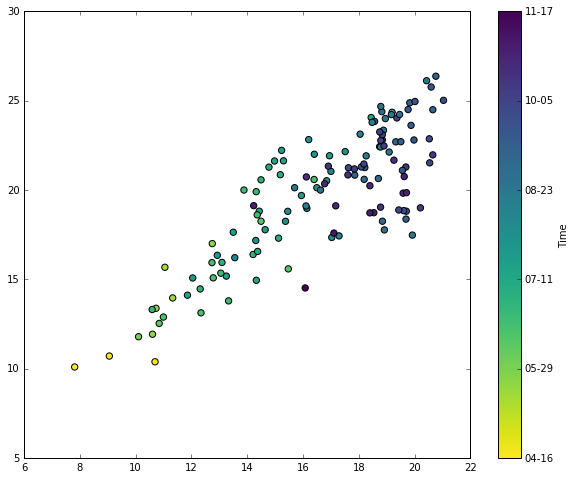

In [36]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_hypo_measure,T_hypo_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

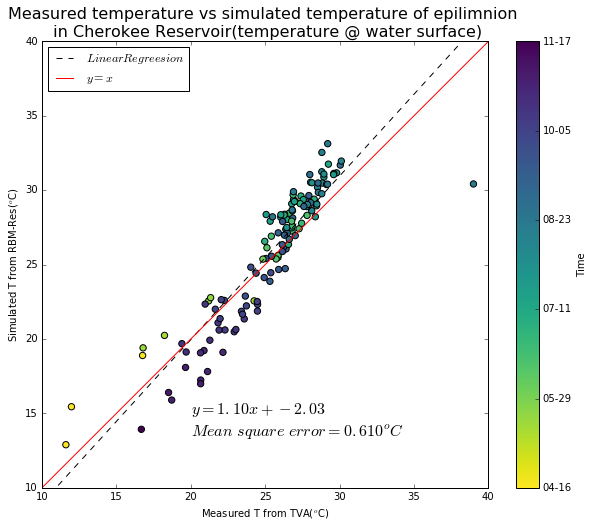

In [35]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_epil_measure,T_epil_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

f1, = plt.plot([10,40],polyval([ar,br],[10,40]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f2, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of epilimnion \n in Cherokee Reservoir(temperature @ water surface)', fontsize = 16)
plt.legend(handles = [f1,f2],loc = 0)
plt.text(20,15,'$y = %s x +%s$'%("{0:.2f}".format(ar),"{0:.2f}".format(br)), fontsize=16)
plt.text(20,13.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err)) + r"$^o C$",fontsize=16)
plt.xlim(10,40)
plt.ylim(10,40)
plt.savefig('Tepil_measured-simulated_cherokee_color_2Depth_fort32.png', dpi=300, bbox_inches='tight')

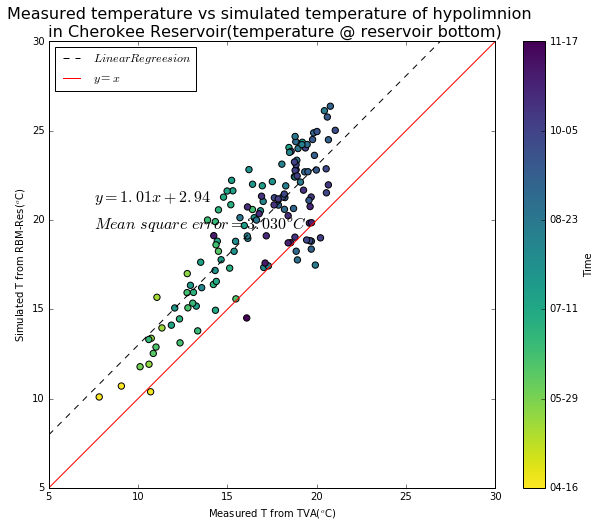

In [34]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_hypo_measure,T_hypo_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

f3, = plt.plot([5,30],polyval([ar1,br1],[5,30]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f4, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of hypolimnion \n in Cherokee Reservoir(temperature @ reservoir bottom)', fontsize = 16)
plt.legend(handles = [f3,f4],loc = 0)
plt.text(7.5,21,'$y = %s x +%s$'%("{0:.2f}".format(ar1),"{0:.2f}".format(br1)), fontsize=16)
plt.text(7.5,19.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err1)) + r"$^o C$",fontsize=16)
plt.xlim(5,30)
plt.ylim(5,30)
plt.savefig('Thypo_measured-simulated_cherokee_updated_color_2Depth_fort32.png', dpi=300, bbox_inches='tight')

## Epilimnion layer: 6.4 m

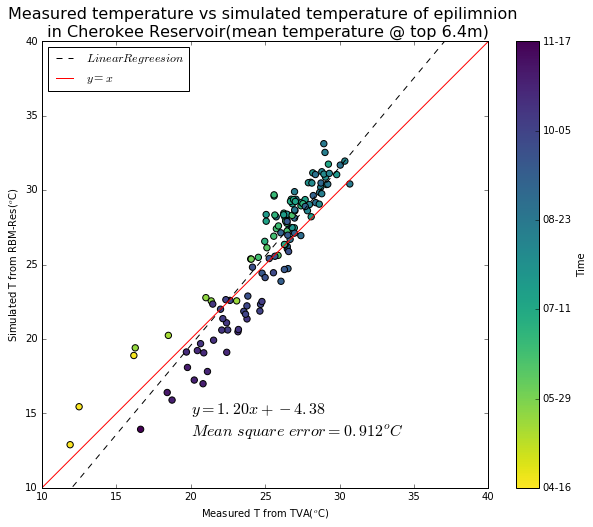

In [33]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_epil_measure_6,T_epil_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

f1, = plt.plot([10,40],polyval([ar2,br2],[10,40]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f2, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of epilimnion \n in Cherokee Reservoir(mean temperature @ top 6.4m)', fontsize = 16)
plt.legend(handles = [f1,f2],loc = 0)
plt.text(20,15,'$y = %s x +%s$'%("{0:.2f}".format(ar2),"{0:.2f}".format(br2)), fontsize=16)
plt.text(20,13.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err2)) + r"$^o C$",fontsize=16)
plt.xlim(10,40)
plt.ylim(10,40)
plt.savefig('Tepil_measured-simulated_cherokee_6_2Depth_fort32.png', dpi=300, bbox_inches='tight')

## hypolimnion layer: 9.6 m

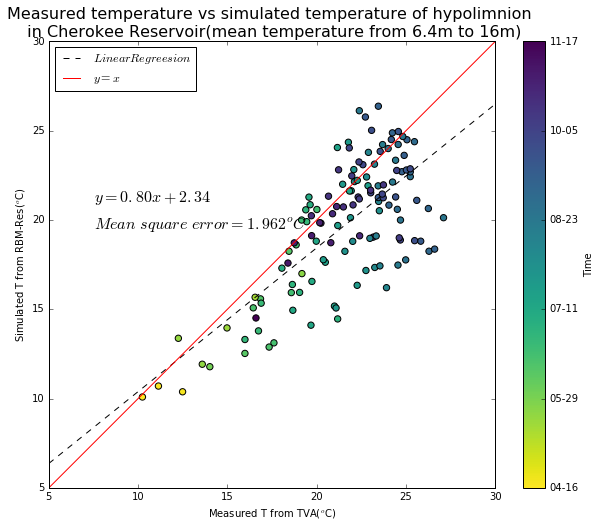

In [32]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_hypo_measure_9,T_hypo_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

#plt.plot(T_hypo_measure_9,T_hypo_model,'o')
f3, = plt.plot([5,30],polyval([ar3,br3],[5,30]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f4, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of hypolimnion \n in Cherokee Reservoir(mean temperature from 6.4m to 16m)', fontsize = 16)
plt.legend(handles = [f3,f4],loc = 0)
plt.text(7.5,21,'$y = %s x +%s$'%("{0:.2f}".format(ar3),"{0:.2f}".format(br3)), fontsize=16)
plt.text(7.5,19.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err3)) + r"$^o C$",fontsize=16)
plt.xlim(5,30)
plt.ylim(5,30)
plt.savefig('Thypo_measured-simulated_cherokee_9_2Depth_fort32.png', dpi=300, bbox_inches='tight')

## hypolimnion layer: 25 m

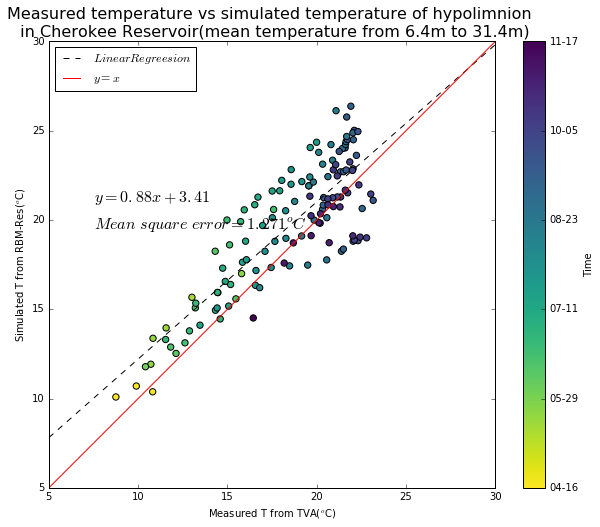

In [31]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_hypo_measure_25,T_hypo_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

#plt.plot(T_hypo_measure_25,T_hypo_model,'o')
f3, = plt.plot([5,30],polyval([ar4,br4],[5,30]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f4, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of hypolimnion \n in Cherokee Reservoir(mean temperature from 6.4m to 31.4m)', fontsize = 16)
plt.legend(handles = [f3,f4],loc = 0)
plt.text(7.5,21,'$y = %s x +%s$'%("{0:.2f}".format(ar4),"{0:.2f}".format(br4)), fontsize=16)
plt.text(7.5,19.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err4)) + r"$^o C$",fontsize=16)
plt.xlim(5,30)
plt.ylim(5,30)
plt.savefig('Thypo_measured-simulated_cherokee_25_2Depth_fort32.png', dpi=300, bbox_inches='tight')

## hypolimnion layer: all rest

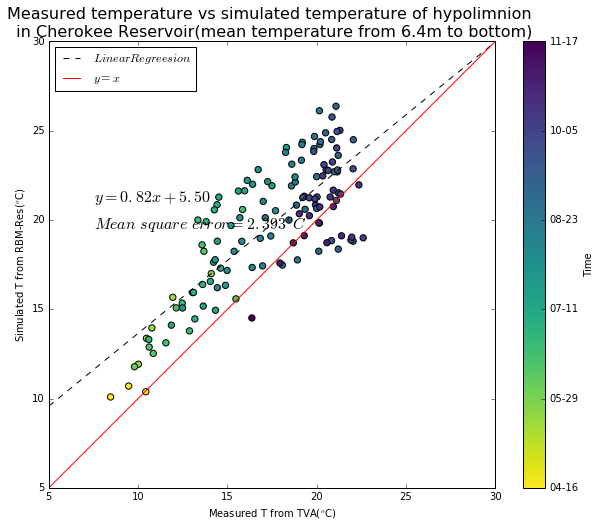

In [30]:
plt.figure(figsize=[10,8])
im = plt.scatter(T_hypo_measure_all,T_hypo_model, s = 40, c = doy,cmap='viridis_r')
cbar = plt.colorbar(im, ticks = index_doy/366)
cbar.set_ticklabels(doy_ticks)
cbar.set_label('Time')

#plt.plot(T_hypo_measure_all,T_hypo_model,'o')
f3, = plt.plot([5,30],polyval([ar5,br5],[5,30]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f4, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of hypolimnion \n in Cherokee Reservoir(mean temperature from 6.4m to bottom)', fontsize = 16)
plt.legend(handles = [f3,f4],loc = 0)
plt.text(7.5,21,'$y = %s x +%s$'%("{0:.2f}".format(ar5),"{0:.2f}".format(br5)), fontsize=16)
plt.text(7.5,19.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err5)) + r"$^o C$",fontsize=16)
plt.xlim(5,30)
plt.ylim(5,30)
plt.savefig('Thypo_measured-simulated_cherokee_all_bottom_2Depth_fort32.png', dpi=300, bbox_inches='tight')

['2009-06-22', '2009-07-01', '2009-07-15', '2009-07-21', '2009-07-29', '2009-08-11', '2009-08-18', '2009-08-25', '2009-09-09', '2009-09-21', '2009-10-06', '2009-10-21', '2009-11-03', '2009-11-17']


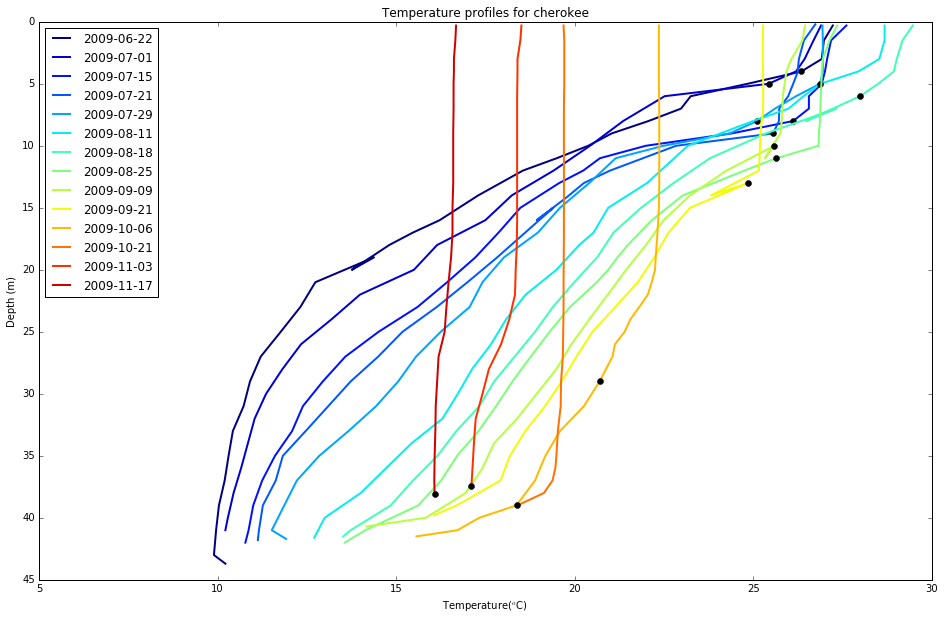

In [50]:
for j in [5]:

    filename = mypath + '/' + onlyfiles[j]
    x = pd.ExcelFile(filename)
    sheet_name = x.sheet_names
    print(sheet_name)
    
    plt.figure(figsize=[16,10])
    plt.xlabel('Temperature(' + r"$^o$" + 'C)', fontsize = 10)
    plt.ylabel('Depth (m)')
    plt.gca().invert_yaxis()
    plt.title('Temperature profiles for cherokee')
    cmap = matplotlib.cm.get_cmap('jet')
    for i in range(len(sheet_name)):
    #for i in range(4):
    #for i in [5]:
        data = x.parse(sheet_name[i], skiprows = [0,2], header = [0])
        f, = plt.plot(data['Temp'],data['Depth'],label = i,linewidth = 2,color = cmap(i/len(sheet_name)))
        plt.plot(combine_temp['temp_depth'].loc[sheet_name[i]],combine_temp['depth_thermalcline'].loc[sheet_name[i]],'ko')
        str1 = sheet_name[i]
        a = re.findall('\d+', str1 )
        legend_date = a[0]+'-'+a[1]+'-'+a[2]
        f.set_label(legend_date)
        plt.legend(loc=0)

#    plt.savefig('measured_temperature_profiles.png', bbox_inche = 'tight', dpi = 300)

In [51]:
int(sheet_name[1][0:4])

2009

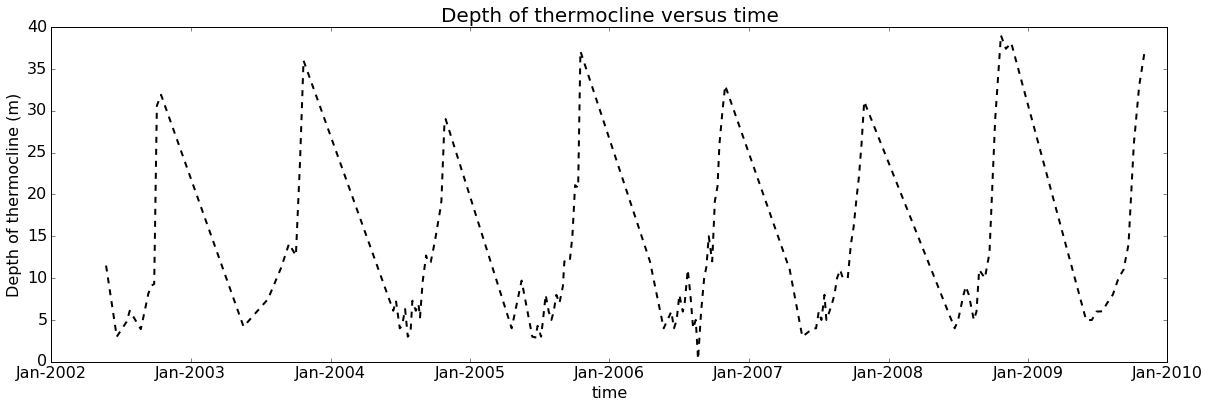

In [52]:
plt.figure(figsize=[20,6])
plt.plot(combine_temp.index ,combine_temp['depth_thermalcline'], 'k--', linewidth=2)
plt.xlabel('time', fontsize=16)
plt.ylabel('Depth of thermocline (m)', fontsize=16)
plt.xticks(pd.date_range('2002-01-01','2011-01-01',freq = 'A'), ['Jan-2002','Jan-2003','Jan-2004', 'Jan-2005','Jan-2006','Jan-2007','Jan-2008'\
                                                                 ,'Jan-2009','Jan-2010'], fontsize=16)
plt.yticks(fontsize=16)
plt.title('Depth of thermocline versus time',fontsize = 20)
#plt.savefig('depth_of_thermocline.png', bbox_inche = 'tight', dpi = 300)

In [53]:
pd.date_range('2003-01-01','2011-01-01',freq = 'A')

DatetimeIndex(['2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31',
               '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')